In [1]:
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm
from xhistogram.xarray import histogram
import os
import time
from matplotlib.colors import LogNorm
import dask

In [2]:
url1 = 'https://iridl.ldeo.columbia.edu/SOURCES/.Models/.SubX/.'
# varying_url = 'ESRL/.FIMr1p1/'
# url2 = '.hindcast/.pr/Y/(23N)/(60N)/RANGEEDGES/X/(140W)/(50W)/RANGEEDGES/S/(Dec)/(Feb)/RANGEEDGES/%5BX/Y%5Daverage/dods'
url2 = '/.hindcast/.'
var_name = ['pr', 'tas', 'tdps', 'wap', 'cape']
url_L = '/L/(0)/(30)/RANGEEDGES'
# url3 = '/Y/(23N)/(60N)/RANGEEDGES/X/(140W)/(50W)/RANGEEDGES/%5BX/Y%5Daverage/dods'  
url3 = '/Y/(23N)/(50N)/RANGEEDGES/X/(130W)/(60W)/RANGEEDGES/dods'  

varying_url = ['ESRL/.FIMr1p1',
               'CESM/.30LCESM1', 'CESM/.46LCESM1',
#                'ECCC/.GEM','ECCC/.GEPS5','ECCC/.GEPS6',
               'EMC/.GEFS',
               'GMAO/.GEOS_V2p1',
               'NRL/.NESM',
               'RSMAS/.CCSM4',
#                'NCEP/.CFSv2'
              ]


var_name = ['pr', 'tas', 'tdps', 'wap', 'cape']
var_name_q1 = ['tas', 'tdps', 'lnwap', 'lncape'] # pr vs.
var_name_q2 = ['tdps', 'lnwap', 'lncape'] # t vs.
var_name_q3 = ['lnwap', 'lncape'] # td vs.
var_name_q4 = 'lncape' # wap vs.

q=[50, 75,85,95,99,99.1,99.5,99.9]
MASK_url = 'http://iridl.ldeo.columbia.edu/expert/SOURCES/.Models/.SubX/'
MASK_url1 = '/.hindcast/.pr'
MASK_url2 = '/dup/.SOURCES/.Features/.Political/.World/.Countries/.the_geom/objectid/135/VALUE/rasterize/dods'

ESRL/.FIMr1p1
CESM/.30LCESM1
CESM/.46LCESM1
ECCC/.GEM


FileNotFoundError: [Errno 2] No such file or directory: b'/local/OWAQ/hist_model_submodel_ECCC_GEM.nc'

<Figure size 432x288 with 0 Axes>

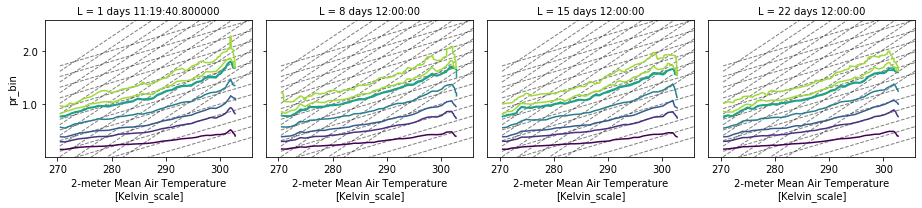

<Figure size 432x288 with 0 Axes>

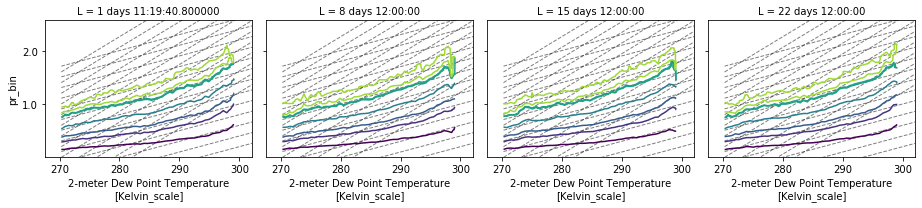

<Figure size 432x288 with 0 Axes>

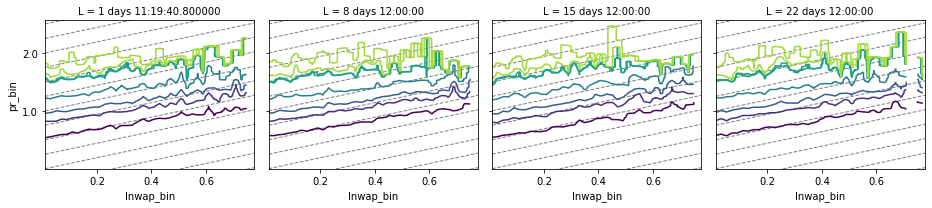

<Figure size 432x288 with 0 Axes>

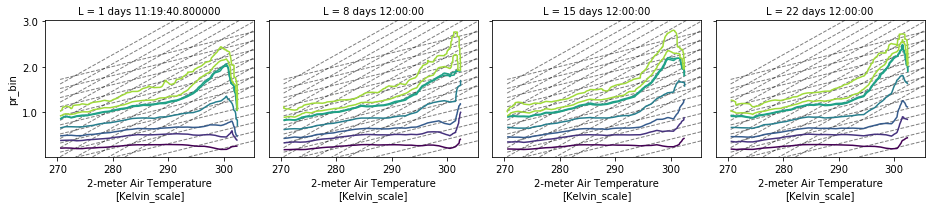

<Figure size 432x288 with 0 Axes>

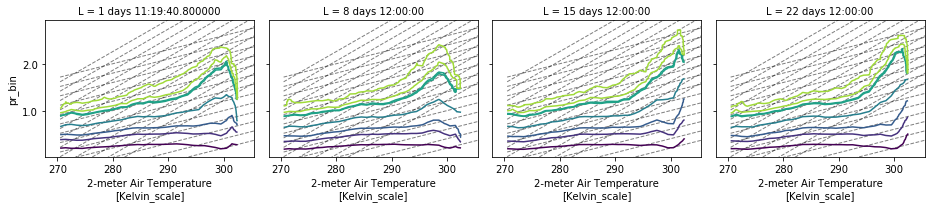

In [13]:
for i_v_u in varying_url:
    print(i_v_u)
    hist_ds = xr.open_dataset('hist_model_submodel_'+i_v_u.replace('/.','_')+'.nc')
    hist_ds = hist_ds.isel(objectid=0, drop=True)

    for dv in hist_ds.data_vars:
        if dv.split('_')[1]=='pr':  
            i_v_n = dv.split('_')[2]

            pr_hist_w_dims = hist_ds[dv]
            # looking at the whole year now
            pr_hist_w_dims = pr_hist_w_dims.sum('S')
            # groupby each week discarding 0.5
            pr_hist_w_dims = pr_hist_w_dims.isel(L=slice(1,None)).groupby_bins('L',bins=4).sum('L')
            # rename it to L and change coordinate to initial itnerval
            # so the plotting doesn't yell at me
            ILv = [IL.left for IL in pr_hist_w_dims.L_bins.values]
            pr_hist_w_dims.coords['L_bins']=ILv
            pr_hist_w_dims = pr_hist_w_dims.rename({'L_bins':'L'})
            
            where_valid = pr_hist_w_dims.where(pr_hist_w_dims>0).count(dim='pr_bin')>25
            

            pr_hist_w_dims = pr_hist_w_dims / pr_hist_w_dims.sum(dim='pr_bin')
            h2d_cum = pr_hist_w_dims.cumsum(dim='pr_bin')

            where_valid.compute()
            to_plot = h2d_cum.where(where_valid>0)
            to_plot.compute()
            
            b_var_bin= pr_hist_w_dims[dv.split('_')[2]+'_bin']
            a_var_bin= pr_hist_w_dims[dv.split('_')[1]+'_bin']


            plt.figure()
            out = to_plot.plot.contour(levels=np.array(q)/100.,col='L', col_wrap=4)

            plt.tight_layout()
            if i_v_n[2]=='c':
                scale_range = np.arange(-2.5,0, 0.25)
                coeff_s = [0.5]
                diffvalue = 0
            elif i_v_n[2]=='w':
                coeff_s = [1]
                scale_range = np.arange(-1, 6, 0.25)
                diffvalue = 0
            else:
                coeff_s = [0.068, 0.034]
                scale_range = np.arange(-0.6, 2, 0.4)
                diffvalue = 273.15   

            for i_axi, axi in enumerate(out.axes.ravel()):
                axi.set_yscale('log', basey=np.e)
                reformatta = axi.get_yticks()
                axi.set_yticks(reformatta)
                axi.set_yticklabels(np.log(reformatta))
                for scale in scale_range:
                    for ic in coeff_s:
                        pr_cc = np.exp(scale +ic*(b_var_bin-diffvalue))
                        axi.plot(b_var_bin, pr_cc, color='k', linestyle='--', linewidth=1, alpha=0.5, zorder=0)
                blim = b_var_bin[where_valid[i_axi]]
                axi.set_xlim(blim[0]*0.99, blim[-1]*1.01)
                axi.set_ylim(a_var_bin[0], a_var_bin[-1]);


    

In [6]:
hist_ds


<xarray.Dataset>
Dimensions:                 (L: 30, S: 939, lncape_bin: 51, lnwap_bin: 67, pr_bin: 199, tas_bin: 51, tdps_bin: 50)
Coordinates:
  * S                       (S) datetime64[ns] 1999-01-06 ... 2016-12-28
  * L                       (L) timedelta64[ns] 0 days 12:00:00 ... 29 days 12:00:00
  * pr_bin                  (pr_bin) float64 1.008 1.023 1.039 ... 20.97 21.3
  * tas_bin                 (tas_bin) float64 270.5 271.5 272.5 ... 319.5 320.5
  * tdps_bin                (tdps_bin) float64 270.4 271.1 271.8 ... 304.0 304.7
  * lnwap_bin               (lnwap_bin) float64 0.015 0.045 ... 1.665 1.695
  * lncape_bin              (lncape_bin) float64 0.085 0.255 ... 8.415 8.585
Data variables:
    histogram_pr_tas        (S, L, pr_bin, tas_bin) int64 ...
    histogram_pr_tdps       (S, L, pr_bin, tdps_bin) int64 ...
    histogram_pr_lnwap      (S, L, pr_bin, lnwap_bin) float64 ...
    histogram_pr_lncape     (S, L, pr_bin, lncape_bin) int64 ...
    histogram_tas_tdps      (S, L

ESRL/.FIMr1p1


/local/ERAin/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/local/ERAin/lib/python3.6/site-packages/xarray/plot/facetgrid.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  subplot_kw=subplot_kws,
/local/ERAin/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see th

CESM/.30LCESM1


/local/ERAin/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/local/ERAin/lib/python3.6/site-packages/xarray/plot/facetgrid.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  subplot_kw=subplot_kws,
/local/ERAin/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see th

CESM/.46LCESM1


/local/ERAin/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/local/ERAin/lib/python3.6/site-packages/xarray/plot/facetgrid.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  subplot_kw=subplot_kws,
/local/ERAin/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see th

EMC/.GEFS


/local/ERAin/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/local/ERAin/lib/python3.6/site-packages/xarray/plot/facetgrid.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  subplot_kw=subplot_kws,
/local/ERAin/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see th

/local/ERAin/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/local/ERAin/lib/python3.6/site-packages/xarray/plot/facetgrid.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  subplot_kw=subplot_kws,
/local/ERAin/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see th

GMAO/.GEOS_V2p1


FileNotFoundError: [Errno 2] No such file or directory: b'/local/OWAQ/hist_model_submodel_GMAO_GEOS_V2p1.nc'

<Figure size 432x288 with 0 Axes>

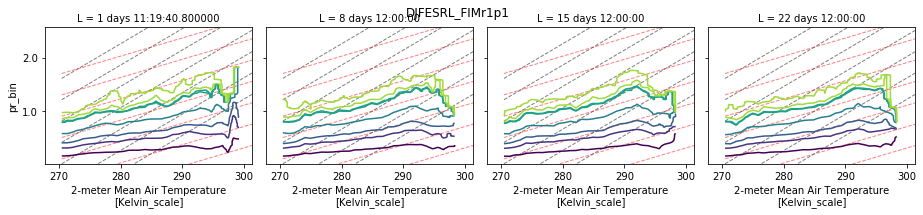

<Figure size 432x288 with 0 Axes>

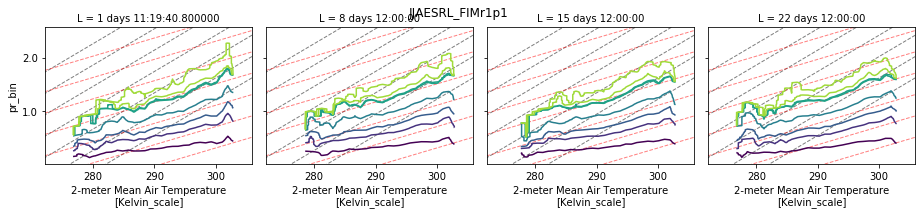

<Figure size 432x288 with 0 Axes>

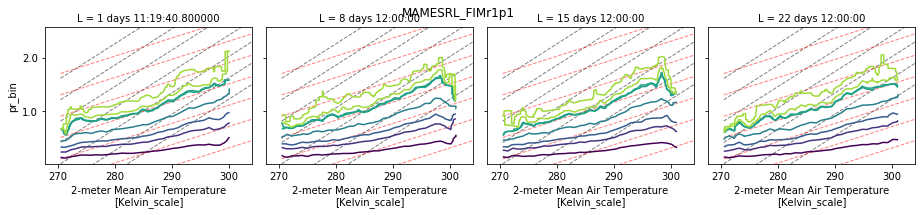

<Figure size 432x288 with 0 Axes>

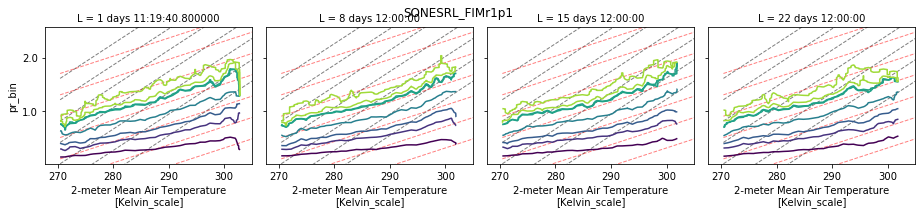

<Figure size 432x288 with 0 Axes>

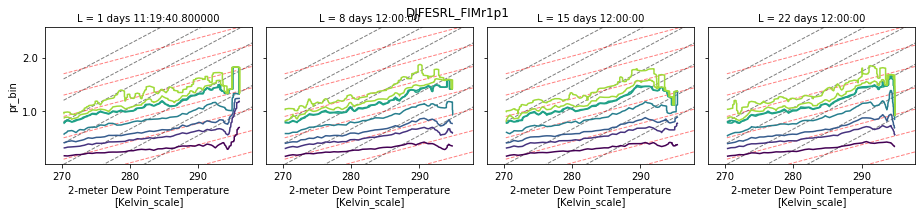

<Figure size 432x288 with 0 Axes>

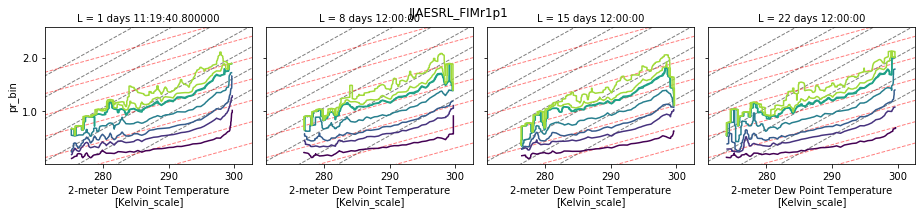

<Figure size 432x288 with 0 Axes>

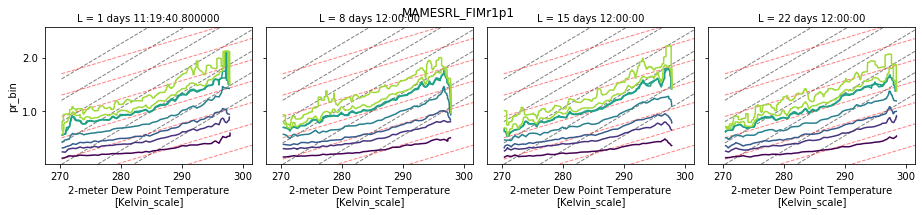

<Figure size 432x288 with 0 Axes>

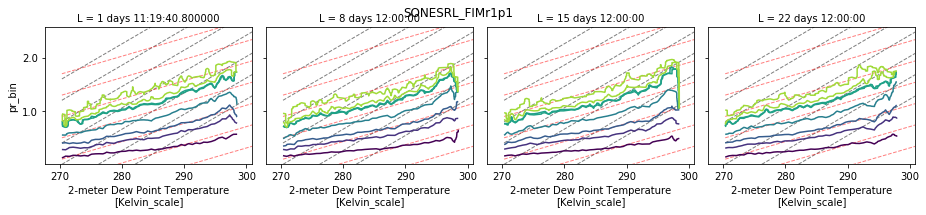

<Figure size 432x288 with 0 Axes>

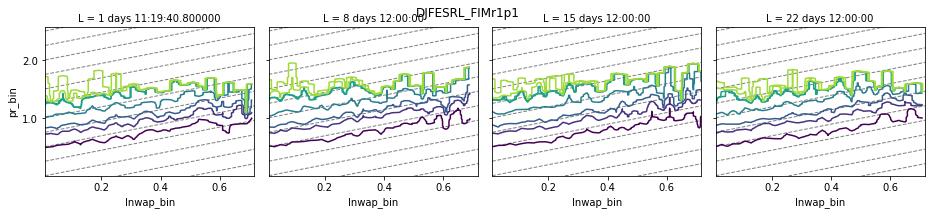

<Figure size 432x288 with 0 Axes>

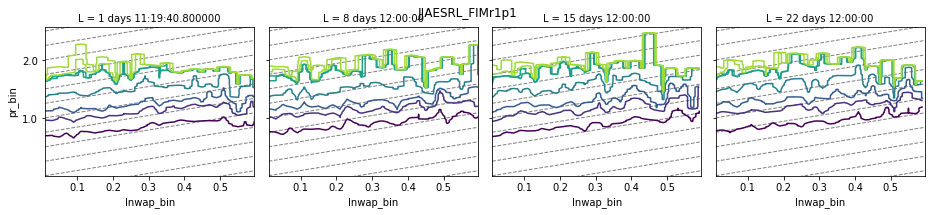

<Figure size 432x288 with 0 Axes>

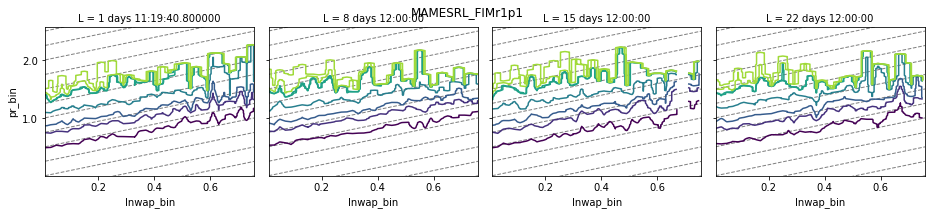

<Figure size 432x288 with 0 Axes>

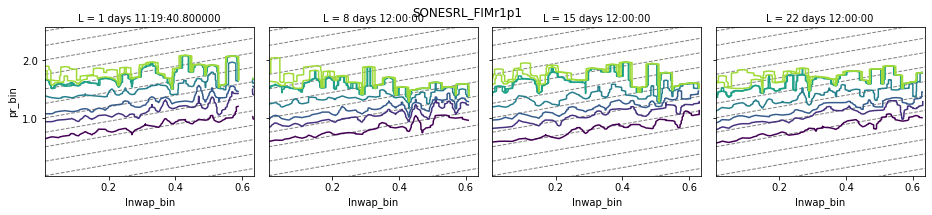

<Figure size 432x288 with 0 Axes>

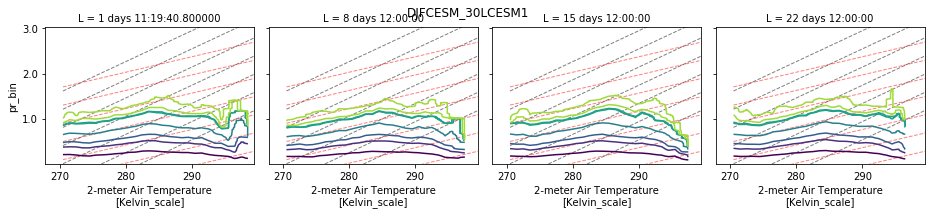

<Figure size 432x288 with 0 Axes>

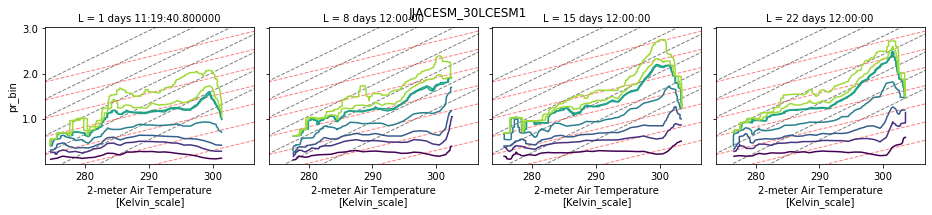

<Figure size 432x288 with 0 Axes>

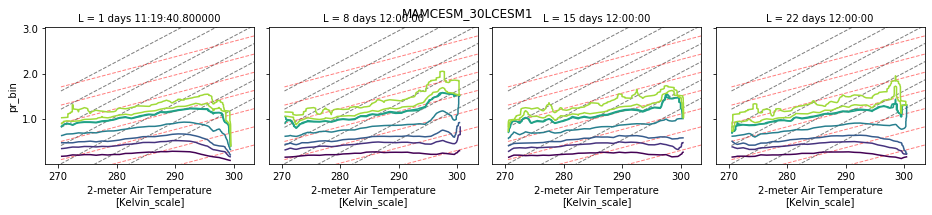

<Figure size 432x288 with 0 Axes>

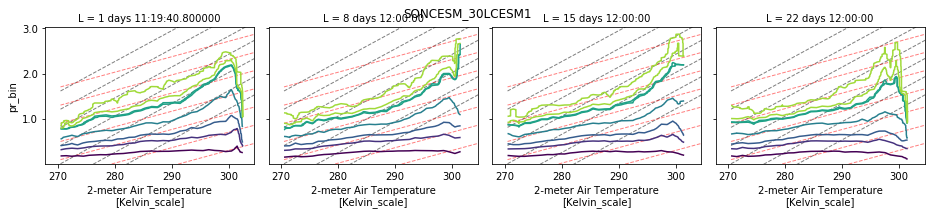

<Figure size 432x288 with 0 Axes>

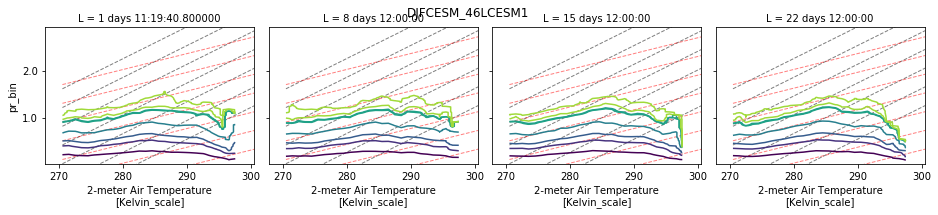

<Figure size 432x288 with 0 Axes>

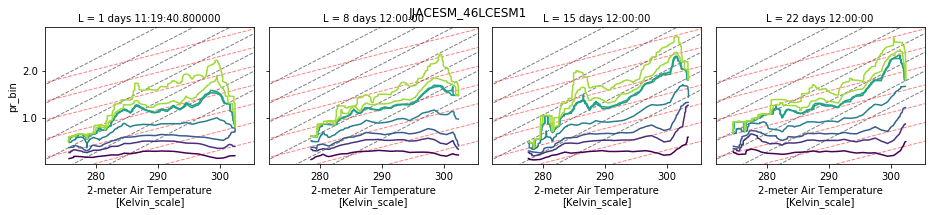

<Figure size 432x288 with 0 Axes>

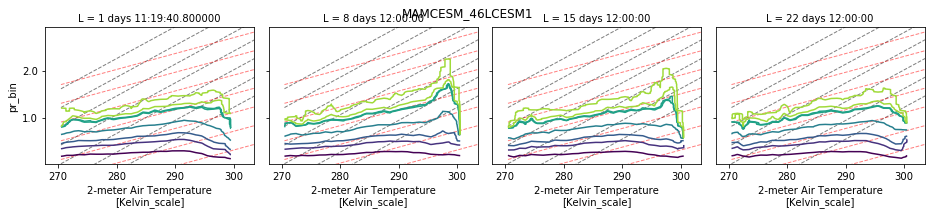

<Figure size 432x288 with 0 Axes>

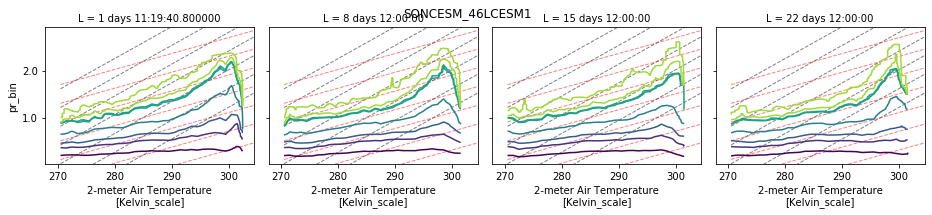

<Figure size 432x288 with 0 Axes>

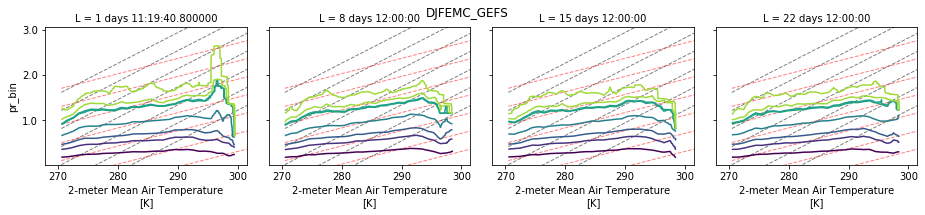

<Figure size 432x288 with 0 Axes>

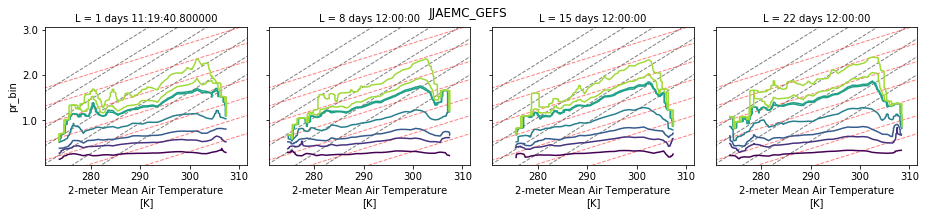

<Figure size 432x288 with 0 Axes>

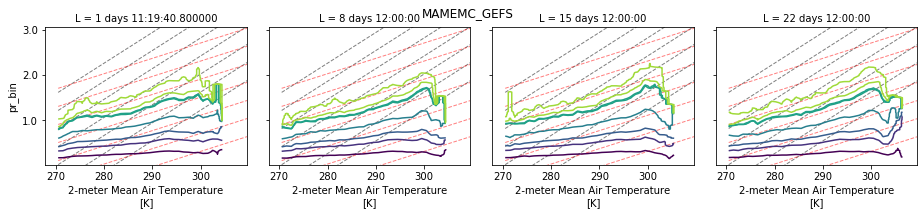

<Figure size 432x288 with 0 Axes>

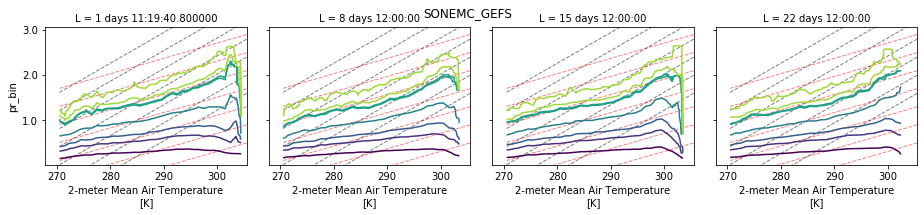

<Figure size 432x288 with 0 Axes>

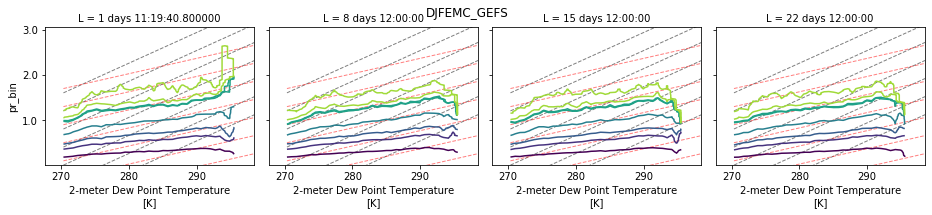

<Figure size 432x288 with 0 Axes>

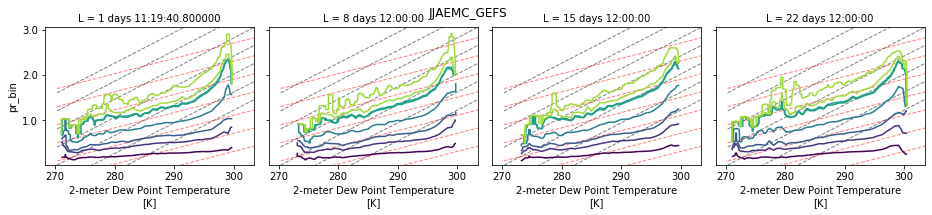

<Figure size 432x288 with 0 Axes>

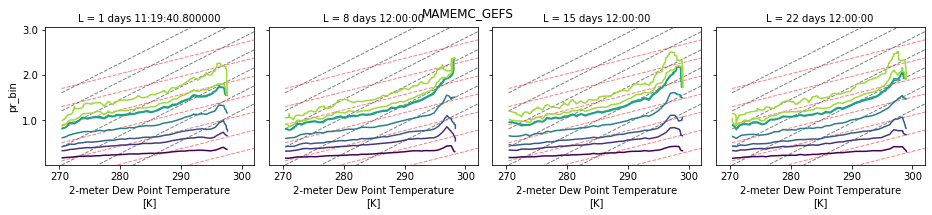

<Figure size 432x288 with 0 Axes>

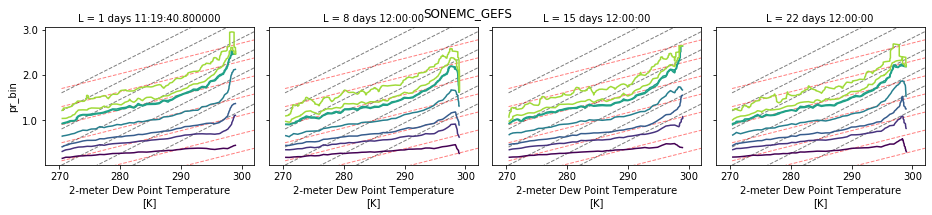

<Figure size 432x288 with 0 Axes>

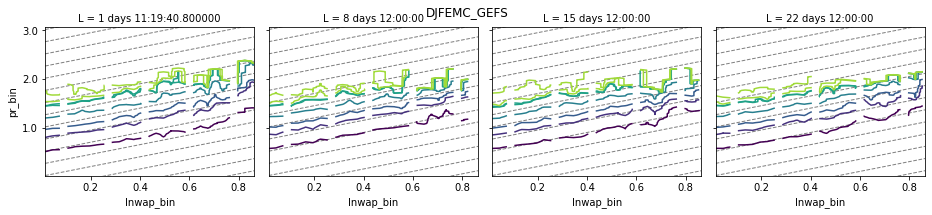

<Figure size 432x288 with 0 Axes>

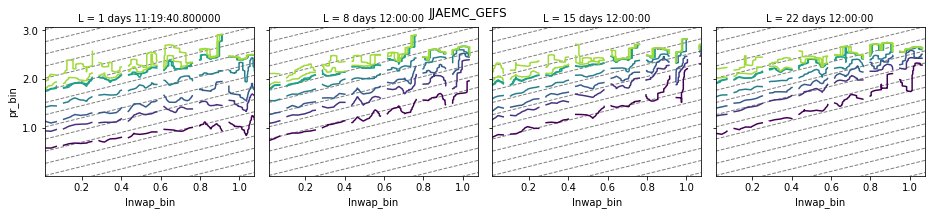

<Figure size 432x288 with 0 Axes>

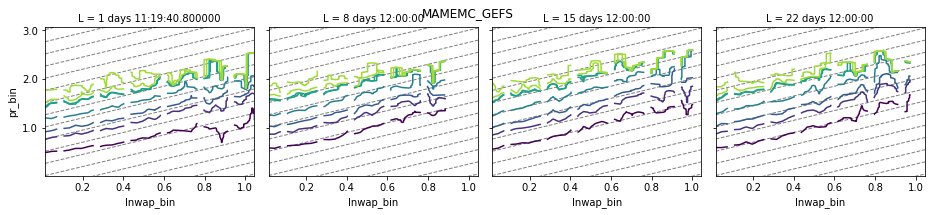

<Figure size 432x288 with 0 Axes>

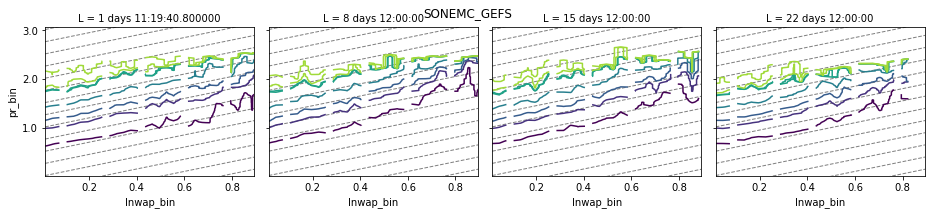

<Figure size 432x288 with 0 Axes>

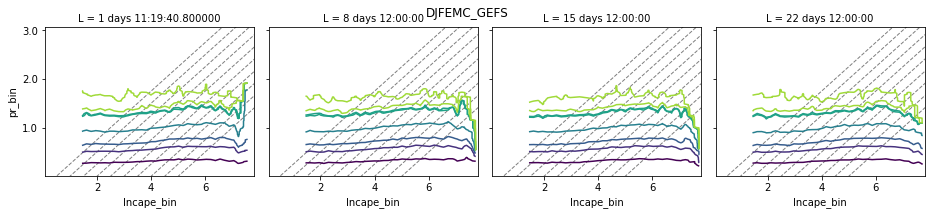

<Figure size 432x288 with 0 Axes>

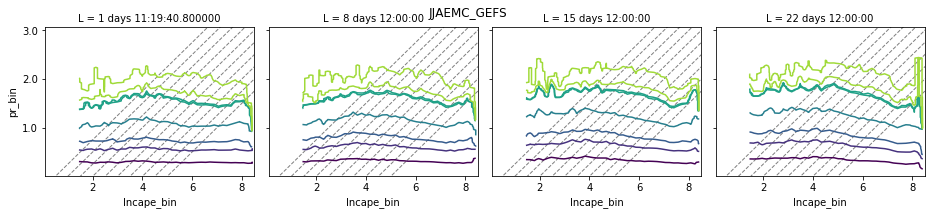

<Figure size 432x288 with 0 Axes>

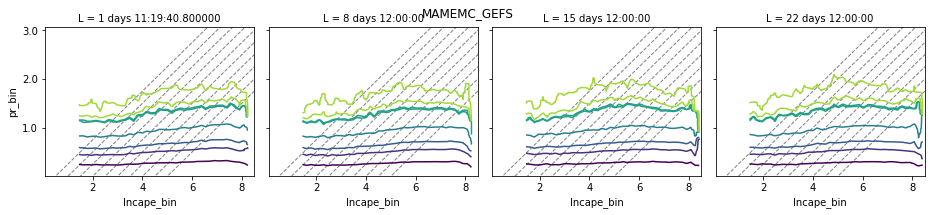

<Figure size 432x288 with 0 Axes>

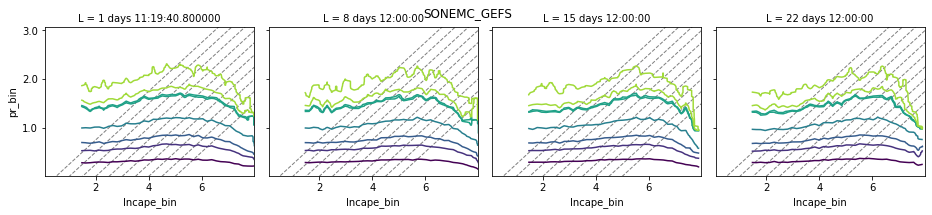

In [7]:
colline=['k','r']
for i_v_u in varying_url:
    print(i_v_u)
    hist_ds = xr.open_dataset('hist_model_submodel_'+i_v_u.replace('/.','_')+'.nc')
    hist_ds = hist_ds.isel(objectid=0, drop=True)
#     hist_ds = hist_ds.sel(Y = slice(32,42), X = slice())
    for dv in hist_ds.data_vars:
        if dv.split('_')[1]=='pr':  
            i_v_n = dv.split('_')[2]

            pr_hist_w_dims = hist_ds[dv]
            # looking at the whole year now
            gp_pr = pr_hist_w_dims.groupby('S.season')
            for k, gp_i in gp_pr:
                # groupby each week discarding 0.5
                gp_i = gp_i.sum('S')
                pr_hist_w_dims = gp_i.isel(L=slice(1,None)).groupby_bins('L',bins=4).sum('L')
                # rename it to L and change coordinate to initial itnerval
                # so the plotting doesn't yell at me
                ILv = [IL.left for IL in pr_hist_w_dims.L_bins.values]
                pr_hist_w_dims.coords['L_bins']=ILv
                pr_hist_w_dims = pr_hist_w_dims.rename({'L_bins':'L'})

                where_valid = pr_hist_w_dims.where(pr_hist_w_dims>0).count(dim='pr_bin')>10


                pr_hist_w_dims = pr_hist_w_dims / pr_hist_w_dims.sum(dim='pr_bin')
                h2d_cum = pr_hist_w_dims.cumsum(dim='pr_bin')

                where_valid.compute()
                to_plot = h2d_cum.where(where_valid>0)
                to_plot.compute()

                b_var_bin= pr_hist_w_dims[dv.split('_')[2]+'_bin']
                a_var_bin= pr_hist_w_dims[dv.split('_')[1]+'_bin']


                plt.figure()
                out = to_plot.plot.contour(levels=np.array(q)/100.,col='L', col_wrap=4)

                plt.tight_layout()
                if i_v_n[2]=='c':
                    scale_range = np.arange(-2.5,0, 0.25)
                    coeff_s = [0.5]
                    diffvalue = 0
                elif i_v_n[2]=='w':
                    coeff_s = [1]
                    scale_range = np.arange(-1, 6, 0.25)
                    diffvalue = 0
                else:
                    coeff_s = [0.068, 0.034]
                    scale_range = np.arange(-0.6, 2, 0.4)
                    diffvalue = 273.15   

                for i_axi, axi in enumerate(out.axes.ravel()):
                    axi.set_yscale('log', basey=np.e)
                    reformatta = axi.get_yticks()
                    axi.set_yticks(reformatta)
                    axi.set_yticklabels(np.log(reformatta))
                    for scale in scale_range:
                        for iic, ic in enumerate(coeff_s):
                            pr_cc = np.exp(scale +ic*(b_var_bin-diffvalue))
                            axi.plot(b_var_bin, pr_cc, color=colline[iic], linestyle='--', linewidth=1, alpha=0.5, zorder=0)
                    blim = b_var_bin[where_valid[i_axi]]
                    axi.set_xlim(blim[0]*0.99, blim[-1]*1.01)
                    axi.set_ylim(a_var_bin[0], a_var_bin[-1]);
                plt.suptitle(k+i_v_u.replace('/.','_'))


    

/local/ERAin/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/local/ERAin/lib/python3.6/site-packages/xarray/plot/facetgrid.py:167: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  subplot_kw=subplot_kws,
/local/ERAin/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see th

<Figure size 432x288 with 0 Axes>

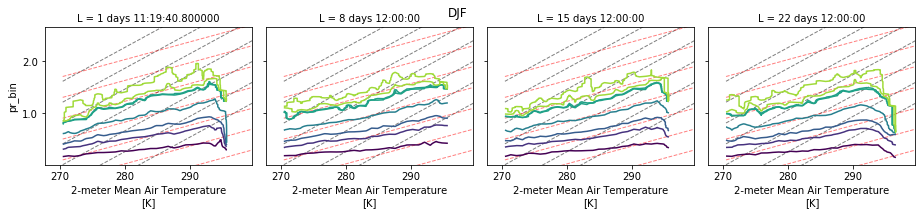

<Figure size 432x288 with 0 Axes>

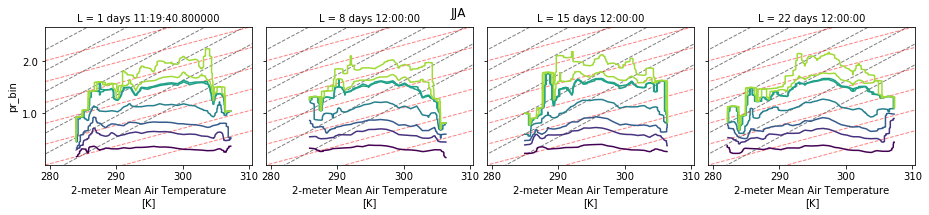

<Figure size 432x288 with 0 Axes>

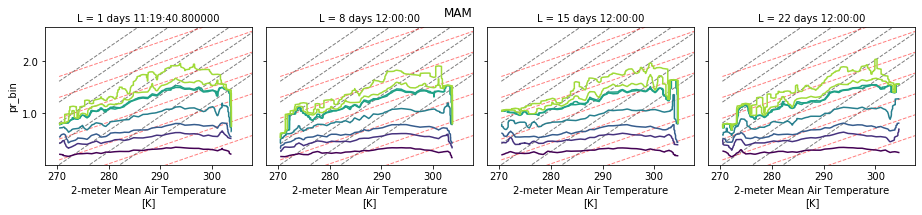

<Figure size 432x288 with 0 Axes>

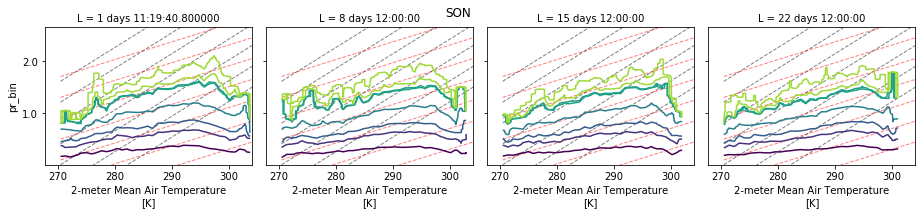

<Figure size 432x288 with 0 Axes>

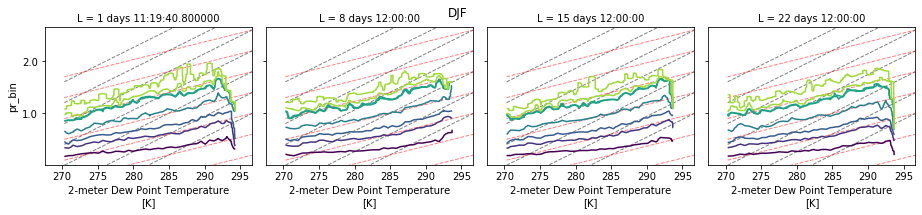

<Figure size 432x288 with 0 Axes>

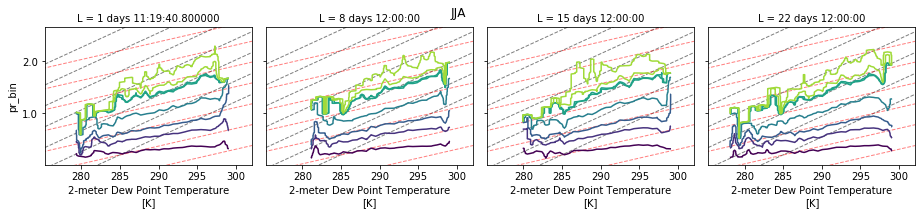

<Figure size 432x288 with 0 Axes>

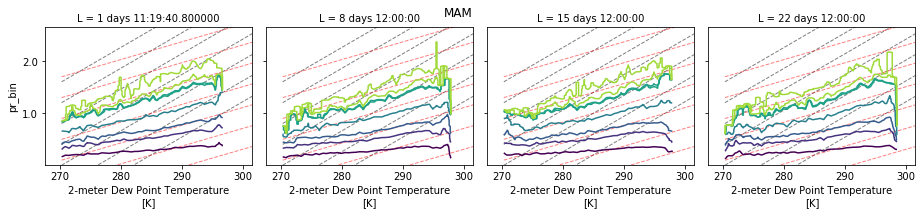

<Figure size 432x288 with 0 Axes>

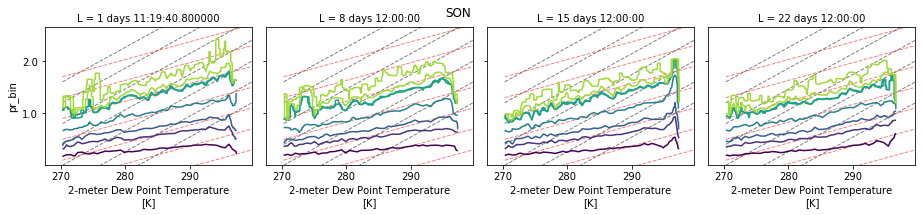

<Figure size 432x288 with 0 Axes>

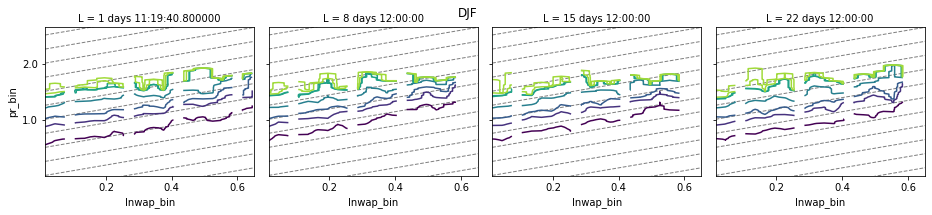

<Figure size 432x288 with 0 Axes>

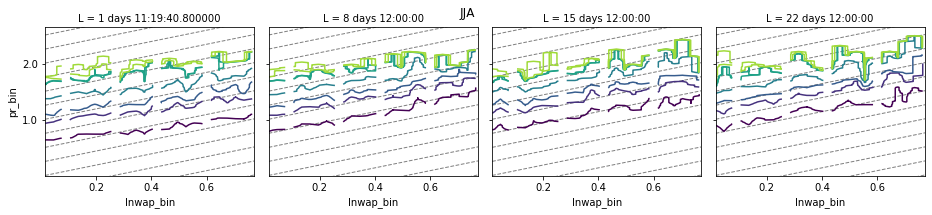

<Figure size 432x288 with 0 Axes>

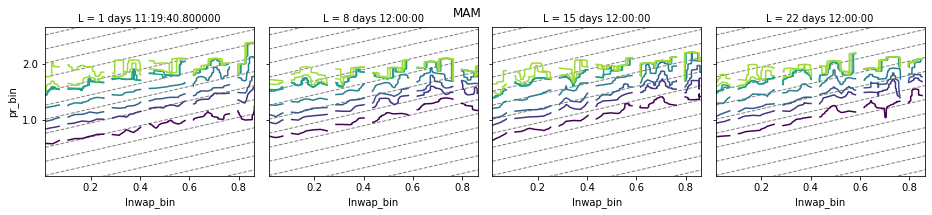

<Figure size 432x288 with 0 Axes>

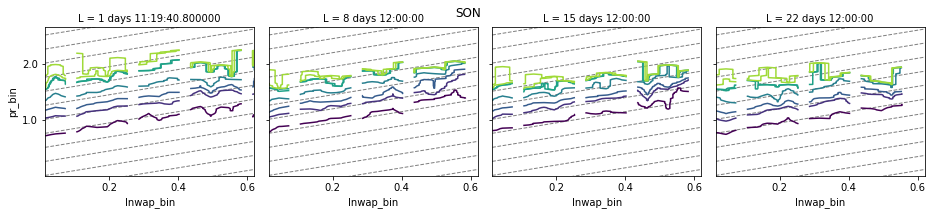

<Figure size 432x288 with 0 Axes>

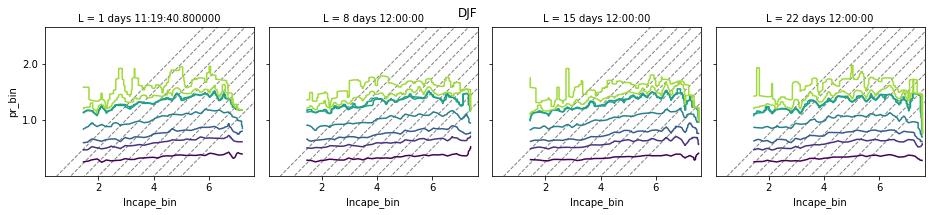

<Figure size 432x288 with 0 Axes>

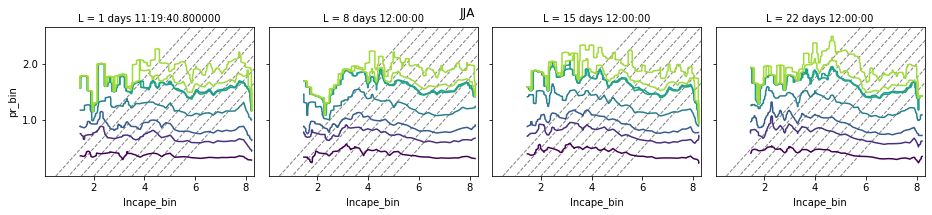

<Figure size 432x288 with 0 Axes>

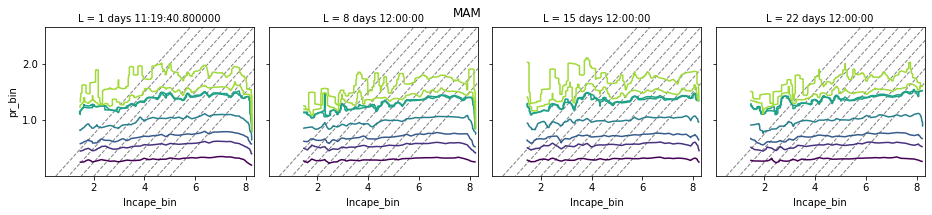

<Figure size 432x288 with 0 Axes>

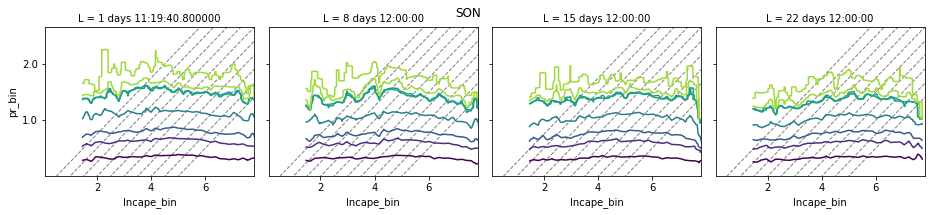

In [13]:
    colline=['k','r']
# for i_v_u in varying_url:
#     print(i_v_u)
    hist_ds = xr.open_dataset('hist_TAregion_model_submodel_EMC_GEFS.nc')
    hist_ds = hist_ds.isel(objectid=0, drop=True)
    hist_ds = hist_ds.isel(P=0, drop=True)
#     hist_ds = hist_ds.sel(Y = slice(32,42), X = slice())
    for dv in hist_ds.data_vars:
        if dv.split('_')[1]=='pr':  
            i_v_n = dv.split('_')[2]

            pr_hist_w_dims = hist_ds[dv]
            # looking at the whole year now
            gp_pr = pr_hist_w_dims.groupby('S.season')
            for k, gp_i in gp_pr:
                # groupby each week discarding 0.5
                gp_i = gp_i.sum('S')
                pr_hist_w_dims = gp_i.isel(L=slice(1,None)).groupby_bins('L',bins=4).sum('L')
                # rename it to L and change coordinate to initial itnerval
                # so the plotting doesn't yell at me
                ILv = [IL.left for IL in pr_hist_w_dims.L_bins.values]
                pr_hist_w_dims.coords['L_bins']=ILv
                pr_hist_w_dims = pr_hist_w_dims.rename({'L_bins':'L'})

                where_valid = pr_hist_w_dims.where(pr_hist_w_dims>0).count(dim='pr_bin')>10


                pr_hist_w_dims = pr_hist_w_dims / pr_hist_w_dims.sum(dim='pr_bin')
                h2d_cum = pr_hist_w_dims.cumsum(dim='pr_bin')

                where_valid.compute()
                to_plot = h2d_cum.where(where_valid>0)
                to_plot.compute()

                b_var_bin= pr_hist_w_dims[dv.split('_')[2]+'_bin']
                a_var_bin= pr_hist_w_dims[dv.split('_')[1]+'_bin']


                plt.figure()
                out = to_plot.plot.contour(levels=np.array(q)/100.,col='L', col_wrap=4)

                plt.tight_layout()
                if i_v_n[2]=='c':
                    scale_range = np.arange(-2.5,0, 0.25)
                    coeff_s = [0.5]
                    diffvalue = 0
                elif i_v_n[2]=='w':
                    coeff_s = [1]
                    scale_range = np.arange(-1, 6, 0.25)
                    diffvalue = 0
                else:
                    coeff_s = [0.068, 0.034]
                    scale_range = np.arange(-0.6, 2, 0.4)
                    diffvalue = 273.15   

                for i_axi, axi in enumerate(out.axes.ravel()):
                    axi.set_yscale('log', basey=np.e)
                    reformatta = axi.get_yticks()
                    axi.set_yticks(reformatta)
                    axi.set_yticklabels(np.log(reformatta))
                    for scale in scale_range:
                        for iic, ic in enumerate(coeff_s):
                            pr_cc = np.exp(scale +ic*(b_var_bin-diffvalue))
                            axi.plot(b_var_bin, pr_cc, color=colline[iic], linestyle='--', linewidth=1, alpha=0.5, zorder=0)
                    blim = b_var_bin[where_valid[i_axi]]
                    axi.set_xlim(blim[0]*0.99, blim[-1]*1.01)
                    axi.set_ylim(a_var_bin[0], a_var_bin[-1]);
                plt.suptitle(k)#+i_v_u.replace('/.','_'))


    

In [11]:
    hist_ds = xr.open_dataset('hist_TAregion_model_submodel_EMC_GEFS.nc')
    hist_ds = hist_ds.isel(objectid=0, drop=True)
    hist_ds.histogram_lnwap_lncape.sum(dim=['L','S'])

<xarray.Dataset>
Dimensions:                 (L: 30, P: 1, S: 939, lncape_bin: 51, lnwap_bin: 62, pr_bin: 199, tas_bin: 55, tdps_bin: 56)
Coordinates:
  * S                       (S) datetime64[ns] 1999-01-06 ... 2016-12-28
  * L                       (L) timedelta64[ns] 0 days 12:00:00 ... 29 days 12:00:00
  * pr_bin                  (pr_bin) float64 1.007 1.02 1.034 ... 13.97 14.16
  * tas_bin                 (tas_bin) float64 270.4 271.3 272.2 ... 318.1 319.0
  * tdps_bin                (tdps_bin) float64 270.3 270.9 271.5 ... 302.7 303.3
  * lnwap_bin               (lnwap_bin) float64 0.015 0.045 ... 1.545 1.575
  * P                       (P) int64 500
  * lncape_bin              (lncape_bin) float64 0.085 0.255 ... 8.415 8.585
Data variables:
    histogram_pr_tas        (S, L, pr_bin, tas_bin) int64 ...
    histogram_pr_tdps       (S, L, pr_bin, tdps_bin) int64 ...
    histogram_pr_lnwap      (S, L, P, pr_bin, lnwap_bin) float64 ...
    histogram_pr_lncape     (S, L, pr_bin, lnca

In [9]:
hist_ds

<xarray.Dataset>
Dimensions:                 (L: 30, P: 1, S: 939, lncape_bin: 51, lnwap_bin: 62, pr_bin: 199, tas_bin: 55, tdps_bin: 56)
Coordinates:
  * S                       (S) datetime64[ns] 1999-01-06 ... 2016-12-28
  * L                       (L) timedelta64[ns] 0 days 12:00:00 ... 29 days 12:00:00
  * pr_bin                  (pr_bin) float64 1.007 1.02 1.034 ... 13.97 14.16
  * tas_bin                 (tas_bin) float64 270.4 271.3 272.2 ... 318.1 319.0
  * tdps_bin                (tdps_bin) float64 270.3 270.9 271.5 ... 302.7 303.3
  * lnwap_bin               (lnwap_bin) float64 0.015 0.045 ... 1.545 1.575
  * P                       (P) int64 500
  * lncape_bin              (lncape_bin) float64 0.085 0.255 ... 8.415 8.585
Data variables:
    histogram_pr_tas        (S, L, pr_bin, tas_bin) int64 ...
    histogram_pr_tdps       (S, L, pr_bin, tdps_bin) int64 ...
    histogram_pr_lnwap      (S, L, P, pr_bin, lnwap_bin) float64 ...
    histogram_pr_lncape     (S, L, pr_bin, lnca

<Figure size 432x288 with 0 Axes>

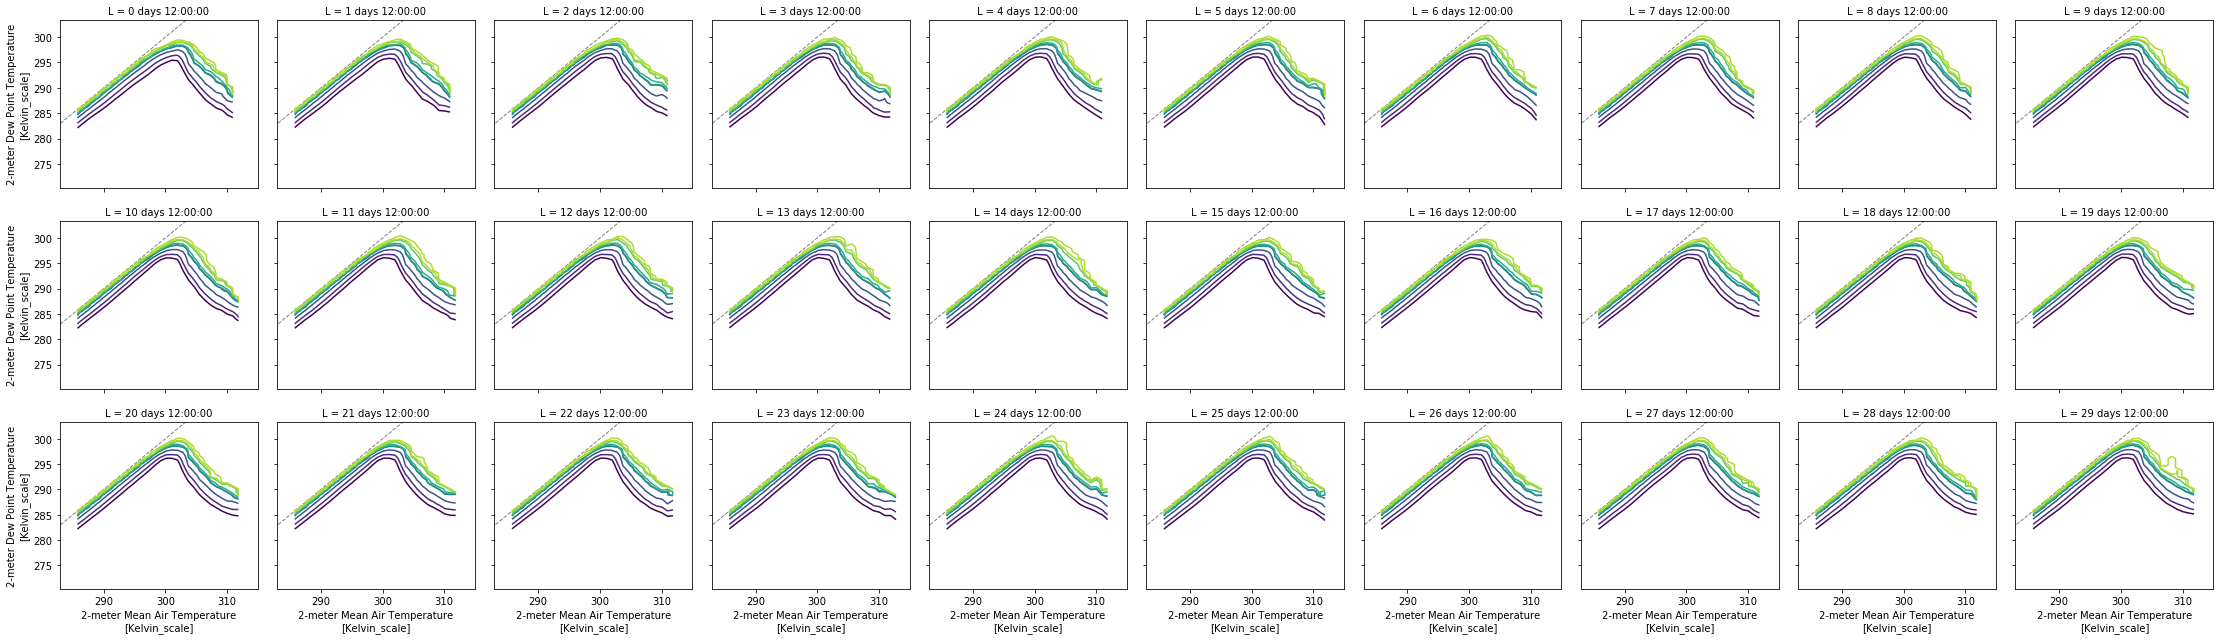

In [55]:
pr_hist_w_dims = hist_ds[dv].sum(dim=['S'])
where_valid = pr_hist_w_dims.where(pr_hist_w_dims>0).count(dim=dv.split('_')[2]+'_bin')>25

pr_hist_w_dims = pr_hist_w_dims / pr_hist_w_dims.sum(dim=dv.split('_')[2]+'_bin')
h2d_cum = pr_hist_w_dims.cumsum(dim=dv.split('_')[2]+'_bin')

where_valid.compute()
to_plot = h2d_cum.where(where_valid>0)
to_plot.compute()

b_var_bin= pr_hist_w_dims[dv.split('_')[1]+'_bin']
a_var_bin= pr_hist_w_dims[dv.split('_')[2]+'_bin']

plt.figure()
out = to_plot.transpose().plot.contour(y=dv.split('_')[2]+'_bin',levels=np.array(q)/100.,col='L', col_wrap=10)
for i_axi, axi in enumerate(out.axes.ravel()):
#     axi.set_yscale('log', basey=np.e)
#     reformatta = axi.get_yticks()
#     axi.set_yticks(reformatta)
#     axi.set_yticklabels(np.log(reformatta))
    axi.plot(b_var_bin, b_var_bin, color='k', linestyle='--', linewidth=1, alpha=0.5, zorder=0)
    blim = b_var_bin[where_valid[i_axi]]
    axi.set_xlim(blim[0]*0.99, blim[-1]*1.01)
    axi.set_ylim(a_var_bin[0], a_var_bin[-1]);


In [48]:
where_valid

<xarray.DataArray 'histogram_tas_tdps' (L: 30, tas_bin: 54)>
array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * L        (L) timedelta64[ns] 0 days 12:00:00 ... 29 days 12:00:00
  * tas_bin  (tas_bin) float64 270.4 271.3 272.2 273.1 ... 316.3 317.2 318.1

In [31]:
to_plot

<xarray.DataArray 'histogram_tdps_lnwap' (L: 30, tdps_bin: 56, lnwap_bin: 67)>
array([[[0.0077821 , 0.01025641, 0.        , ...,        nan,
                nan,        nan],
        [0.01167315, 0.01025641, 0.        , ...,        nan,
                nan,        nan],
        [0.0155642 , 0.01538462, 0.00520833, ...,        nan,
                nan,        nan],
        ...,
        [1.        , 1.        , 1.        , ...,        nan,
                nan,        nan],
        [1.        , 1.        , 1.        , ...,        nan,
                nan,        nan],
        [1.        , 1.        , 1.        , ...,        nan,
                nan,        nan]],

       [[0.        , 0.00332226, 0.00809717, ...,        nan,
                nan,        nan],
        [0.01581028, 0.00332226, 0.01214575, ...,        nan,
                nan,        nan],
        [0.01976285, 0.01993355, 0.0242915 , ...,        nan,
                nan,        nan],
        ...,
        [1.        , 1.      